In [1]:
import matplotlib.pyplot as plt
import statistics
import re
import numpy as np
import pickle
import pandas as pd

# Data Loading

In [2]:
input_path = "./data/data.csv"

df = pd.read_csv(input_path, encoding='utf-8')

In [3]:
len(df)

232736

In [4]:
df.head()

,english,french
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


# Data Preprocessing

In [5]:
input_characters = set()
target_characters = set()

for _, row in df.iterrows():
    input_text = row['english'] 
    target_text = row['french']
    
    input_characters.update(input_text)
    target_characters.update(target_text)

## Data Exploration

### Exploring Characters

Since we will be doing a character level tokenization, we must be careful on what characters are present in the dataset.

In [6]:
print("Unique English characters:\n", sorted(input_characters))
print("Unique French characters:\n", sorted(target_characters))

Unique English characters:
 [' ', '!', '"', '$', '%', '&', "'", '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '\xad', '°', 'é', 'ï', 'ú', 'ü', '–', '—', '‘', '’', '₂', '€']
Unique French characters:
 [' ', '!', '"', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '«', '°', '»', 'À', 'Â', 'Ç', 'É', 'Ê', 'Ô', 'à', 'á', 'â', 'ç', 'è', 'é', 'ê', 'ë',

In [ ]:
count = 0
symbol = "-"

rows_with_symbol = df[(df['english'].str.contains(symbol)) | (df['french'].str.contains(symbol))]

for index, row in rows_with_symbol.iterrows():
    count += 1

print(f"Number of rows with symbol '{symbol}':", count)

        

Number of rows with symbol '-': 41333


## Text Normalization and Preprocessing

- **Lowercasing**: All text (both English and French) will be **converted to lowercase** to simplify the task. This helps the model focus on the content without worrying about casing.
- **Tokenization**: Character-level tokenization will be used. Each character is one-hot encoded, and sentences are padded to a consistent length.
- **Start and End Tokens**: Special start (`\t`) and end (`\n`) tokens will be **added to the target (French) sentences** to help the model learn when to begin and stop generating translations.
- **Padding**: Sentences will be padded up to the maximum allowed length, with any longer sentences being filtered out.

## Special Characters Handling

After analyzing the dataset, the following insights and actions were derived for handling special characters:

- **&**: Appears only once (in "R&B"). It will be replaced with the word **"and"**.
- **‘ ’**: Curly apostrophes will be **replaced with straight apostrophes** (`'`) for consistency.
- **‽**: The rare occurrence of an interrobang (`‽`) will be **replaced with a question mark** (`?`).
- **! " ; - – —**: These symbols will be **removed**
- **$ %**: Rows with these will be **dropped**
- **' , . ?**: Common punctuation marks will be **kept as-is**, as they are important for sentence structure and meaning.
- **+**: Appears in specific contexts (e.g., "C++", "A+") and the rows containing it will be **dropped**.
- **( )**: Parentheses are used only once for explanation, so the rows containing them will be **dropped**.
- **/**: Appears only in one language per row, so the rows containing it will be **dropped** to avoid inconsistencies.
- **₂**: Appears in chemical formulas (e.g., "H₂O") and rows will be **dropped"**.
- **« »**: French quotation marks will be **removed**.
- **°**: Represents temperature (e.g., "30°C"), but appears only three times in the dataset, so the rows containing it will be **dropped**.
- **:**: Used in time (e.g., "3:30") and in French text structures (e.g., "dis : …"). It will be **removed**.
- **€**: Appears only once as a currency symbol (e.g., "€30"), so the row containing it will be **dropped**.
- All accented charecters will be normalized (eg. é turns to e) to optimize the tokens size.
- All rows containing digits will be dropped.

### Handling data with digits

In [8]:
def contains_digits(text):
    return any(char.isdigit() for char in text)

In [9]:
# Create a boolean mask for rows that contain digits
mask = df['english'].str.contains(r'\d') | df['french'].str.contains(r'\d')

filtered_df = df[mask]

only_english = 0
only_french = 0
both = 0

texts_with_digits = []

# Iterate through the filtered DataFrame
for _, row in filtered_df.iterrows():
    english_contains = contains_digits(row['english']) 
    french_contains = contains_digits(row['french'])  
    
    if english_contains and not french_contains:
        only_english += 1
        texts_with_digits.append((row['english'], row['french']))
    elif french_contains and not english_contains:
        only_french += 1
        texts_with_digits.append((row['english'], row['french']))
    elif english_contains and french_contains:
        both += 1
        texts_with_digits.append((row['english'], row['french']))

print(f"{only_english=} {only_french=} {both=} total={len(texts_with_digits)}")

only_english=335 only_french=225 both=809 total=1369


In [10]:
texts_with_digits[1]

("Here's $5.", 'Voilà cinq dollars.')

In [11]:
texts_with_digits[9]

("I'm 99% sure.", "J'en suis sûr à 99%.")

We notice some inconsistencies in the data. **335 sentences** in English contain numerical values that are represented as textual strings in the French translation.

*Example:* **Here's $5** => **Voilà cinq dollars.**

In this case, **$5** is translated to **cinq dollars**, which can confuse the model. Therefore, it is better to drop rows that contain digits in one language only, especially since they are underrepresented in the dataset: **335 examples** out of **230k** (≈ **0.1%**).

Some other occurrences of numerical values can be seen in both languages.

*Example:* **I'm 99% sure.** => **J'en suis sûr à 99%.**

This is consistent and can be left in the training data, but it is also a rare occurrence, with only **809 examples** out of **230k** (≈ **0.3%**).

Because the goal is to create a model that handles the translation of simple sentences, and numerical values are misrepresented in our data, we can simply discard them and drop rows with digits. This can also be beneficial as it reduces the number of tokens.


In [ ]:
def normalize_whitespace(text):
    pattern = r'[\s\xa0\xad\u200b]+'

    text = re.sub(pattern, ' ', text)

    return text.strip()

def clean_special_characters(sentence, language):
    # character replacements based on language
    replacements = {
        'common': {
            "&": "and",
            "‘": "'", "’": "'",
            "‽": "?", 
            "–": " ", "—": "", 
            "-": " ", "!": "",
            "\"": "", ":": "", ";": "",
            "«": "", "»": ""
        },
        'english': {
            "ï": "i", "ú": "u", "ü": "u", "é": "e"
        },
        'french': {
            "á": "a", "ü": "u", "ō": "o", "è": "e", "é": "e",
            "ê": "e", "ë": "e", "î": "i", "ï": "i", "ô": "o",
            "ù": "u", "û": "u", "œ": "oe", "ç": "c", "à": "a",
            "â": "a"
        }
    }
    
    for char, replacement in replacements['common'].items():
        sentence = sentence.replace(char, replacement)
    
    if language in replacements:
        for char, replacement in replacements[language].items():
            sentence = sentence.replace(char, replacement)

    return sentence

def remove_inconsistent_symbols(input_text, target_text, symbols):
    for symbol in symbols:
        if symbol in input_text and symbol not in target_text:
            input_text = input_text.replace(symbol, "")
        elif symbol in target_text and symbol not in input_text:
            target_text = target_text.replace(symbol, "")
    
    return input_text, target_text

def normalize_sentence(sentence, language):
    sentence = sentence.lower()

    sentence = clean_special_characters(sentence, language)

    sentence = normalize_whitespace(sentence)

    if language == 'french':
        sentence =  "\t" + sentence + "\n"
    return sentence

def filter_function(row):
    symbols = set("₂°+/€()$%0123456789")  
    combined_text = row['english'] + row['french']
    return not any(symbol in symbols for symbol in combined_text)

In [13]:
new_df = df.copy()

In [14]:
new_df['english'] = df['english'].apply(lambda x: normalize_sentence(x, 'english'))
new_df['french'] = df['french'].apply(lambda x: normalize_sentence(x, 'french'))

In [15]:
new_df = new_df[new_df.apply(filter_function, axis=1)]

Rebuild characters set

In [17]:
input_characters = set()
target_characters = set()

for input_text, target_text in zip(new_df["english"], new_df["french"]):
    input_characters.update(input_text) 
    target_characters.update(target_text)

In [18]:
print("English:\n",sorted(input_characters))
print("French:\n",sorted(target_characters))

English:
 [' ', "'", ',', '.', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
French:
 ['\t', '\n', ' ', "'", ',', '.', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Dropping duplicates

In [22]:
print("Size of the dataset with duplicates:", len(new_df))

df_unique = new_df.drop_duplicates(subset="english").drop_duplicates(subset="french")

print("Size of the dataset without duplicates:", len(df_unique))

Size of the dataset with duplicates: 231362
Size of the dataset without duplicates: 147538


In [24]:
new_df = df_unique

### Exploring lengths

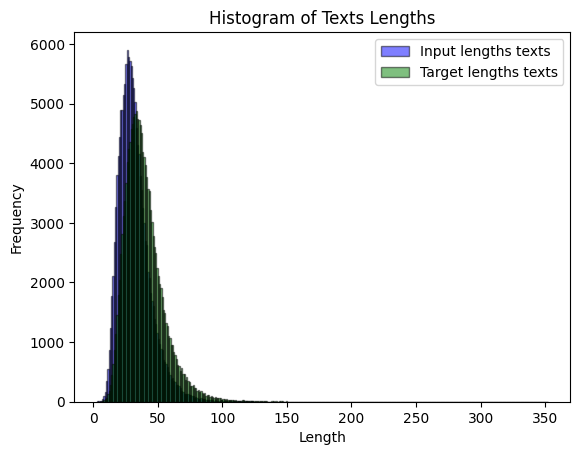

In [25]:
input_lengths = [len(s) for s in new_df["english"]]
target_lengths = [len(s) for s in new_df["french"]]

plt.hist(input_lengths, bins=range(min(input_lengths + target_lengths), max(input_lengths + target_lengths) + 2), 
         alpha=0.5, label='Input lengths texts', color='blue', edgecolor='black')
plt.hist(target_lengths, bins=range(min(input_lengths + target_lengths), max(input_lengths + target_lengths) + 2), 
         alpha=0.5, label='Target lengths texts', color='green', edgecolor='black')

plt.title('Histogram of Texts Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

In [26]:
def calculate_statistics(string_lengths):
    min_length = np.min(string_lengths)
    max_length = np.max(string_lengths)
    mean_length = statistics.mean(string_lengths)
    median_length = statistics.median(string_lengths)
    percentile_95 = np.percentile(string_lengths, 95)
    percentile_5 = np.percentile(string_lengths, 5)

    stats = {
        "min": min_length,
        "max": max_length,
        "mean": mean_length,
        "median": median_length,
        "95th_percentile": percentile_95,
        "5th_percentile": percentile_5,
    }

    return stats

In [27]:
print("English:")
print(calculate_statistics(input_lengths))
print("French:")
print(calculate_statistics(target_lengths))

English:
{'min': 3, 'max': 286, 'mean': 31.5118952405482, 'median': 29.0, '95th_percentile': 55.0, '5th_percentile': 16.0}
French:
{'min': 4, 'max': 351, 'mean': 38.88568368827014, 'median': 36.0, '95th_percentile': 67.0, '5th_percentile': 20.0}


In [28]:
def calculate_filtered_string_stats(string_list,lower_bound,upper_bound):
    filtered_by_lower = sum(1 for s in string_list if len(s) < lower_bound)
    
    filtered_by_upper = sum(1 for s in string_list if len(s) > upper_bound)

    total_filtered = filtered_by_lower + filtered_by_upper
    
    total_strings = len(string_list)
    
    stats = {
        "filtered_by_lower": f"{filtered_by_lower} {filtered_by_lower/total_strings:.2%}",
        "filtered_by_upper": f"{filtered_by_upper} {filtered_by_upper/total_strings:.2%}",
        "total_filtered": f"{total_filtered} {total_filtered/total_strings:.2%}",
        "total_remaining": f"{(total_strings - total_filtered)} {(total_strings - total_filtered)/total_strings:.2%}"
    }
    
    return stats

In [40]:
lower_bound = 10
upper_bound = 65

print(f"English texts lengths:")
print(calculate_filtered_string_stats(new_df["english"], lower_bound,upper_bound))
print(f"French texts lengths:")
print(calculate_filtered_string_stats(new_df["french"], lower_bound,upper_bound))

English texts lengths:
{'filtered_by_lower': '347 0.24%', 'filtered_by_upper': '2798 1.90%', 'total_filtered': '3145 2.13%', 'total_remaining': '144393 97.87%'}
French texts lengths:
{'filtered_by_lower': '85 0.06%', 'filtered_by_upper': '8207 5.56%', 'total_filtered': '8292 5.62%', 'total_remaining': '139246 94.38%'}


## Filtering Data Based On Sequence Length

In [41]:
def filter_short_sentences(df, lower_threshold, upper_threshold):
    
    filtered_df = df[
        (df["english"].str.len() >= lower_threshold) &
        (df["english"].str.len() <= upper_threshold) &
        (df["french"].str.len() >= lower_threshold) &
        (df["french"].str.len() <= upper_threshold)
    ]
    return filtered_df

In [42]:
new_df = filter_short_sentences(new_df, lower_bound, upper_bound)

In [52]:
index = 15000

new_df.iloc[index]

english              stop being a baby.
french     \tarrete de faire le bebe.\n
Name: 29105, dtype: object

In [54]:
len(new_df)

138803

### Shuffling and Sampling

- A random sample of **50k examples** is selected for training.

In [56]:
num_sentences = 50000  

selected_indices = np.random.choice(new_df.index, size=num_sentences, replace=False)

sampled_df = new_df.loc[selected_indices].reset_index(drop=True)

### Viewing our data

In [59]:
example = 999

sampled_df.iloc[index]

english                   i know how to drive a car.
french     \tje sais comment conduire une voiture.\n
Name: 15000, dtype: object

In [60]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in sampled_df["english"]])
max_decoder_seq_length = max([len(txt) for txt in sampled_df["french"]])

In [61]:
print("Number of samples:", len(sampled_df))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 50000
Number of unique input tokens: 31
Number of unique output tokens: 33
Max sequence length for inputs: 65
Max sequence length for outputs: 65


## Creating tokens dictionary

In [62]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

### Encoding the data

In [63]:
encoder_input_data = np.zeros(
    (len(sampled_df), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data = np.zeros(
    (len(sampled_df), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
decoder_target_data = np.zeros(
    (len(sampled_df), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

In [ ]:
for i in range(len(sampled_df)):
    input_text, target_text = sampled_df["english"][i], sampled_df["french"][i]
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data contains one character ahead than decoder_input_data
        # and will not include the start character.
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

## Saving the data

In [65]:
data_to_save = {
    'encoder_input_data': encoder_input_data,
    'decoder_input_data': decoder_input_data,
    'decoder_target_data': decoder_target_data
}

pickle_file = './data/data.pkl'

with open(pickle_file, 'wb') as file:
    pickle.dump(data_to_save, file)

print(f"Data saved to {pickle_file}")

Data saved to ./data/data.pkl


In [66]:
data_to_save = {
    'target_token_index': target_token_index,
    'input_token_index': input_token_index,
}

pickle_file = './data/index.pkl'

with open(pickle_file, 'wb') as file:
    pickle.dump(data_to_save, file)

print(f"Data saved to {pickle_file}")

Data saved to ./data/index.pkl
